In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '../..')))

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
import cv2
from scipy.signal import find_peaks

from collections import defaultdict
from sklearn.cluster import KMeans
from skimage.restoration import denoise_wavelet

from hydracv.fluorescence import trace_fluo

In [3]:
FILEPATH = '../data/videos/NGCaMP/'
FILENAME = 'ngcamp_660frames_enhanced.avi'

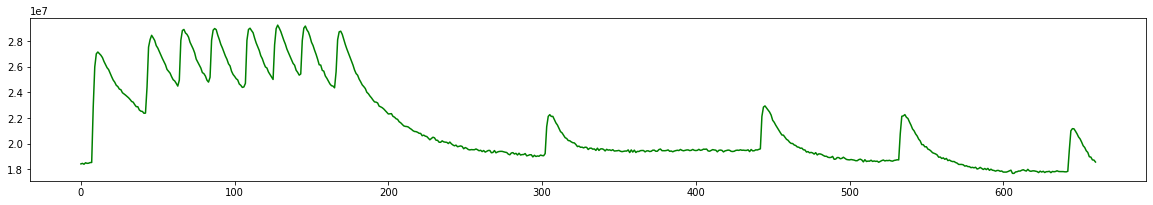

In [4]:
# Trace total fluorescence
fluo = trace_fluo.trace(FILEPATH + FILENAME, display=False)
plt.figure(figsize=(20,3))
plt.plot(fluo, 'g')
plt.show()

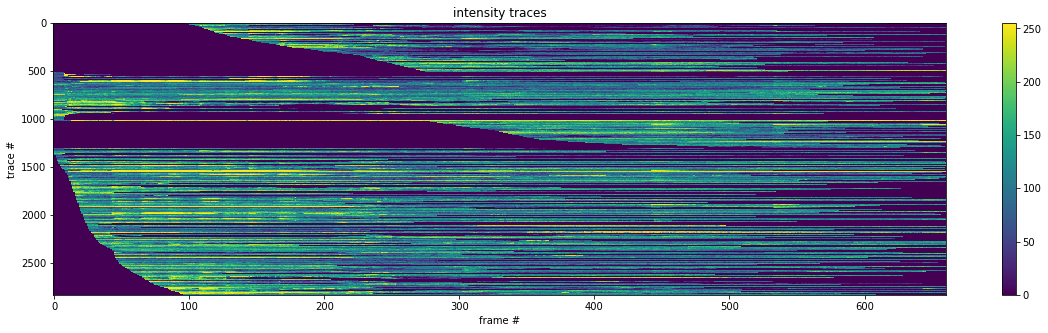

In [5]:
# Load intensity traces

FLUOPATH = "/home/hengji/Data/hydracv/hydracv/data/tracks/intensity/"
FLUOPREFIX = "ngcamp_660frames_enhanced_tracks_"
dfs = []

for file in os.listdir(FLUOPATH):
    if file.startswith(FLUOPREFIX) and file.endswith('.xls'):
        dfs.append(pd.read_excel(FLUOPATH + file, header=None))

traces = np.array(np.copy(pd.concat(dfs, axis=1).drop([0], axis=1).fillna(0)[1:].values), dtype=float).T
plt.figure(figsize=(20, 5))
plt.imshow(traces, aspect='auto')
plt.xlabel('frame #')
plt.ylabel('trace #')
plt.colorbar()
plt.title('intensity traces')
plt.show()

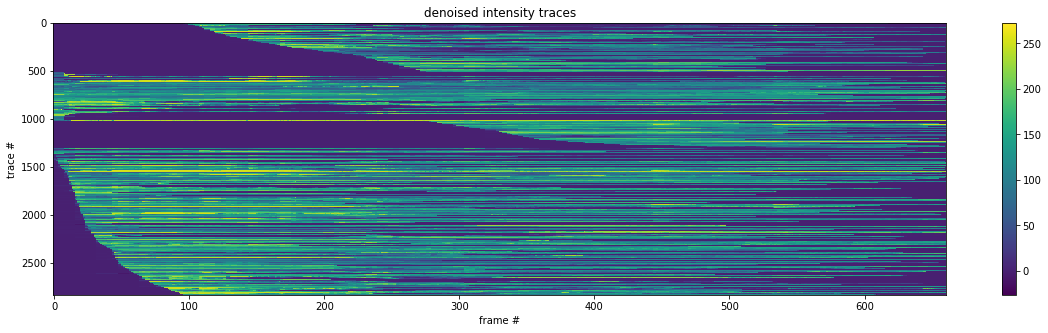

In [6]:
# Denoise traces

traces_denoised = []

for trace in traces:
    traces_denoised.append(denoise_wavelet(trace, multichannel=False, method='BayesShrink', mode='soft', rescale_sigma=True))
    
traces_denoised = np.array(traces_denoised)
plt.figure(figsize=(20, 5))
plt.imshow(traces_denoised, aspect='auto')
plt.xlabel('frame #')
plt.ylabel('trace #')
plt.colorbar()
plt.title('denoised intensity traces')
plt.show()

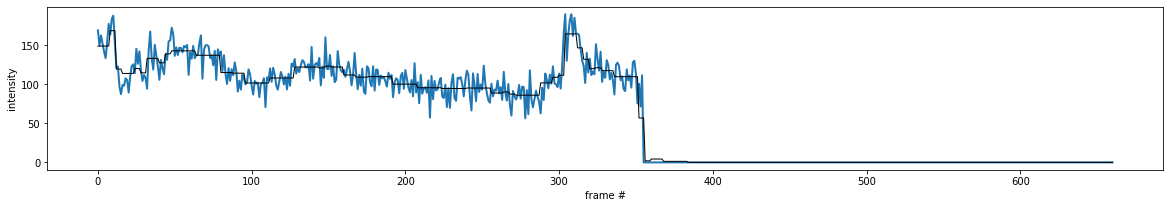

In [25]:
# Check denoising on single neuron
index = 690
plt.figure(figsize=(20,3))
plt.plot(traces[index], label='original', linewidth=2)
plt.plot(traces_denoised[index], 'k', label='denoised', linewidth=1)
plt.xlabel('frame #')
plt.ylabel('intensity')
plt.show()

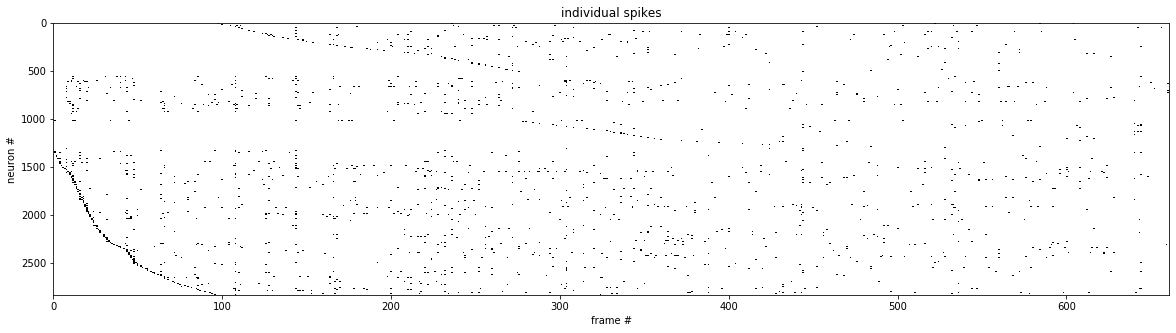

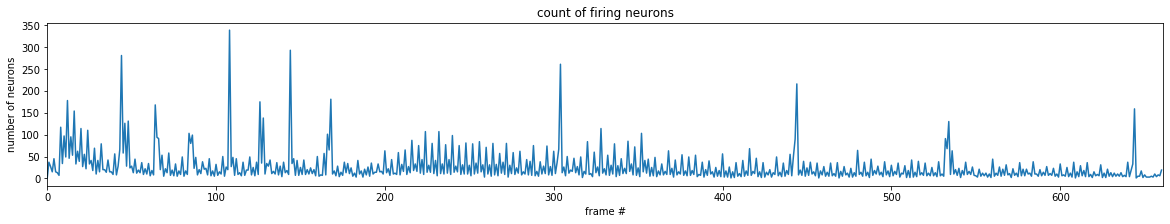

In [26]:
# Extract individual spikes
spikes = np.zeros(traces_denoised.shape)

for i, trace in enumerate(traces_denoised):
    deriv = [0]
    for j in range(1, traces.shape[1]):
        x = trace[j] - trace[j-1]
        if x > 0:
            deriv.append(x)
        else:
            deriv.append(0)
    deriv = np.array(deriv)
    nindex = int(sum(deriv > 0) * 0.1)
    if nindex == 0:
        continue
    else:
        ktopindex = sorted(deriv.argsort()[-nindex:])
        spikes[i][ktopindex] = 1

count_fire = np.sum(spikes, axis=0)
    
plt.figure(figsize=(20,5))
plt.imshow(spikes, aspect='auto', cmap='binary')
plt.xlim(0, len(count_fire))
plt.xlabel('frame #')
plt.ylabel('neuron #')
plt.title('individual spikes')
plt.show()

plt.figure(figsize=(20,3))
plt.plot(count_fire)
plt.xlim(0, len(count_fire))
plt.xlabel('frame #')
plt.ylabel('number of neurons')
plt.title('count of firing neurons')
plt.show()

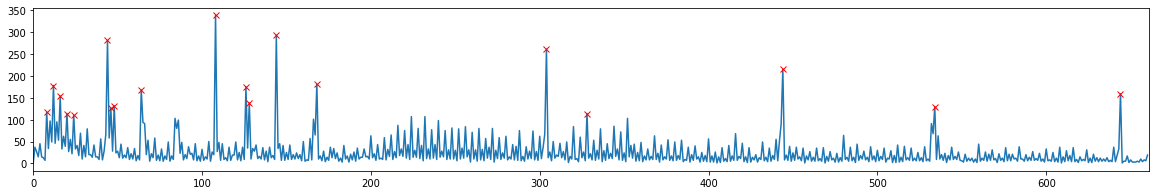

In [36]:
# Indentify peaks
nindex = int(len(count_fire) * 0.03)
peaks = sorted(count_fire.argsort()[-nindex:])
# wlen = 10

# peaks_ = [peaks[0]]
# for i in range(1, len(peaks)):
#     if peaks[i] - peaks[i-1] < wlen:
#         if count_fire[peaks[i]] < count_fire[peaks[i-1]]:
#             continue
#         else:
#             peaks_.pop()
#     peaks_.append(peaks[i])
# peaks = peaks_

plt.figure(figsize=(20,3))
plt.plot(count_fire)
plt.plot(peaks, count_fire[list(peaks)], 'rx')
plt.xlim(0, len(count_fire))
plt.show()

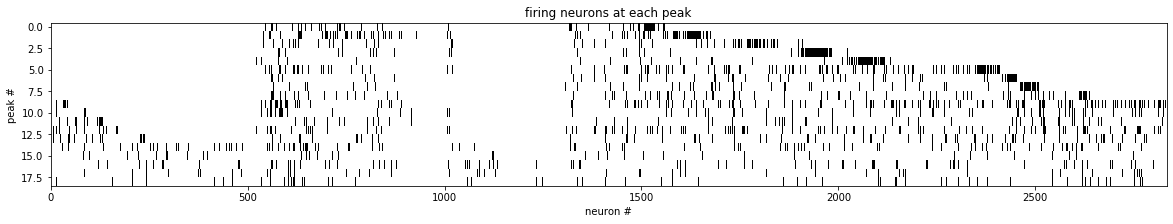

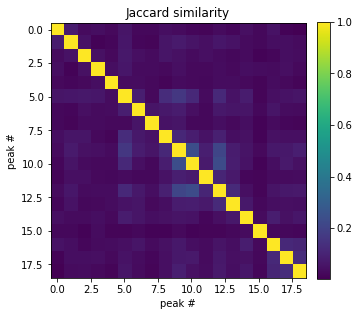

In [37]:
# Similarity between peaks

peak_vectors = []
for peak in peaks:
    vector = []
    for train in spikes:
        vector.append(train[peak])
    peak_vectors.append(vector)

peak_vectors = np.array(peak_vectors)

plt.figure(figsize=(20,3))
plt.imshow(peak_vectors, aspect='auto', cmap='binary')
plt.xlabel('neuron #')
plt.ylabel('peak #')
plt.title('firing neurons at each peak')
plt.show()

npeaks = len(peaks)
sim_mat = np.zeros((npeaks, npeaks))
for i in range(npeaks):
    for j in range(i, npeaks):
        sim_mat[i, j] = np.sum(peak_vectors[i] * peak_vectors[j]) / np.sum(peak_vectors[i] + peak_vectors[j] > 0)
        sim_mat[j, i] = sim_mat[i, j]

plt.figure(figsize=(5,5))
im = plt.imshow(sim_mat, aspect='equal')
plt.xlabel('peak #')
plt.ylabel('peak #')
plt.title('Jaccard similarity')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.show()

In [58]:
# K-means cluster on peaks
# ...

In [40]:
# Cluster neuron ensembles
peak_ensemble1 = peaks[:14]
peak_ensemble2 = peaks[14:]

cluster1 = []
cluster2 = []
for i, train in enumerate(spikes):
    count1 = 0
    for peak in peak_ensemble1:
        if train[peak] == 1:
            count1 += 1
            if count1 > 0.3 * len(peak_ensemble1):
                break
    if count1 > 0.3 * len(peak_ensemble1):
        cluster1.append(i)
        continue
        
    count2 = 0
    for peak in peak_ensemble2:
        if train[peak] == 1:
            count2 += 1
            if count2 > 0.5 * len(peak_ensemble2):
                break
    if count2 > 0.5 * len(peak_ensemble2):
        cluster2.append(i)

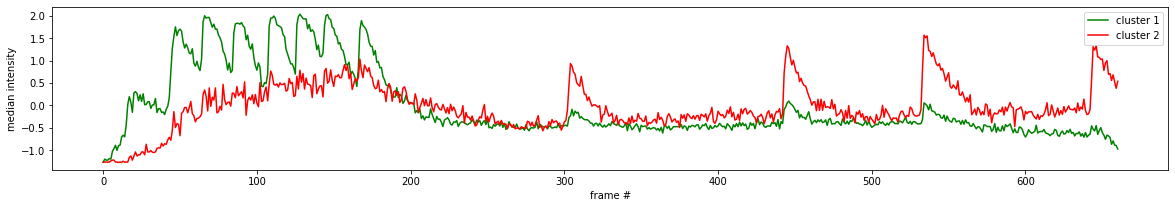

In [41]:
# Median fluorescence traces
traces1 = np.array([(traces[i] - np.mean(traces[i])) / np.std(traces[i]) for i in cluster1])
traces2 = np.array([(traces[i] - np.mean(traces[i])) / np.std(traces[i]) for i in cluster2])

plt.figure(figsize=(20,3))
plt.plot(np.median(traces1, axis=0), color='g', label='cluster 1')
plt.plot(np.median(traces2, axis=0), color='r', label='cluster 2')
plt.xlabel('frame #')
plt.ylabel('median intensity')
plt.legend()
plt.show()

In [97]:
# Locate neurons

# Load all frames
frames = []
vidcap = cv2.VideoCapture(FILEPATH + FILENAME)
success,image = vidcap.read()
count = 0

while success:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    frames.append(image)
    success, image = vidcap.read()
frames = np.array(frames)

# Parse the tracks
TRACKPATH = "/home/hengji/Data/hydracv/hydracv/data/tracks/"
root = ET.parse(TRACKPATH + 'ngcamp_660frames_tracks.xml').getroot()
tracks_xml = root.find('trackgroup').findall('track')

# tracks = np.zeros((len(tracks_xml), len(fluo)))
for i, track_xml in enumerate(tracks_xml):
    detections = track_xml.findall('detection')
    for detection in detections:
        t = int(detection.get('t'))
        # Here: how to handle the float?
        x = int(float(detection.get('x')))
        y = int(float(detection.get('y')))
#         tracks[i][t] = frames[t, y, x]